In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import geemap
import ee
import pandas as pd
import geopandas as gpd
from pyproj import Proj, transform
import os
from tqdm import tqdm
import pickle

In [2]:
try:
    ee.Initialize()
    print("Initialization successful")
except Exception as e:
    print(f"Error: authentication needed")
    ee.Authenticate()
    ee.Initialize()
    print("Initialization successful")


Initialization successful


In [38]:
#TS function
def dailyNBARmaskFunc(img):
    qa = img.select('BRDF_Albedo_Band_Mandatory_Quality_Band1')
    qa2 = img.select('BRDF_Albedo_Band_Mandatory_Quality_Band2')
    Quality = bitwiseExtract(qa, 0)
    Qualityb2 = bitwiseExtract(qa2, 0)
    mask = Quality.eq(0)\
        .And(Qualityb2.eq(0))\


    maskedImage = img.updateMask(mask)

    return maskedImage

def dailyNBARNDVI(img):
    ndvi = img.normalizedDifference(['Nadir_Reflectance_Band2', 'Nadir_Reflectance_Band1']).rename('NDVI').set('system:time_start', img.get('system:time_start'))
    return img.addBands(ndvi)

def bitwiseExtract(value, fromBit, toBit=None):
    '''
    https://gis.stackexchange.com/questions/349371/creating-cloud-free-images-out-of-a-mod09a1-modis-image-in-gee/349401#349401
    '''
    if toBit == None:
        toBit = fromBit
    maskSize = ee.Number(1).add(toBit).subtract(fromBit)
    mask = ee.Number(1).leftShift(maskSize).subtract(1)
    return value.rightShift(fromBit).bitwiseAnd(mask)

def Getroi(img):
    
    maskedImage = img.clip(roi)
    
    return maskedImage
def rescale(image):
    date = image.get('system:time_start')
    return image.multiply(scale_factor).set('system:time_start', date)

def createTS(image):
    date = image.get('system:time_start')
    value = image.reduceRegion(reducer=ee.Reducer.mean(), geometry=roi).get(var)
    std = image.reduceRegion(reducer=ee.Reducer.stdDev(), geometry=roi).get(var)
    ft = ee.Feature(None, {'date': ee.Date(date).format('Y/M/d'), var: value, 'STD': std})
    return ft

def TS_to_pandas(TS):
    dump = TS.getInfo()
    fts = dump['features']
    out_vals = np.empty((len(fts)))
    out_dates = []
    out_std = np.empty((len(fts)))
    
    for i, f in enumerate(fts):
        props = f['properties']
        date = props['date']
        val = props[var]
        std = props['STD']
        out_vals[i] = val
        out_std[i] = std
        out_dates.append(pd.Timestamp(date))
    
    df = pd.DataFrame({'mean' : out_vals, 'std' : out_std}, index=out_dates)
    return df


#GEE interpolation cloud comp
#credit https://spatialthoughts.com/2021/11/08/temporal-interpolation-gee/
def interpolate(image):
    image = ee.Image(image)
    date = image.get('system:time_start')
    beforeImages = ee.List(image.get('before'))
    beforeMosaic = ee.ImageCollection.fromImages(beforeImages).mosaic()
    afterImages = ee.List(image.get('after'))
    afterMosaic = ee.ImageCollection.fromImages(afterImages).mosaic()
    
    t1 = beforeMosaic.select('timestamp').rename('t1')
    t2 = afterMosaic.select('timestamp').rename('t2')
    t = image.metadata('system:time_start').rename('t')
    tImage = ee.Image.cat([t1, t2, t])
    timeRatio = tImage.expression('(t - t1) / (t2 - t1)', {'t': tImage.select('t'),'t1': tImage.select('t1'),'t2': tImage.select('t2')})

    interpolated = beforeMosaic.add((afterMosaic.subtract(beforeMosaic).multiply(timeRatio)))
    result = image.unmask(interpolated)
    return result.copyProperties(image, ['system:time_start'])

def timeImage(image):
    tI = image.metadata('system:time_start').rename('timestamp')
    timeImageMasked = tI.updateMask(image.mask().select(14))
    return image.select('NDVI').addBands(timeImageMasked)

def getsiteNDVI(roiall, NDVICollection, siteID, y_start, y_end, n):
    coords = roiall.getInfo()['features'][siteID]['geometry']['coordinates']
    global roi
    roi = ee.Geometry.MultiPolygon(coords)

    NDVI_flt = NDVICollection.filter(ee.Filter.date(y_start, y_end))
    NDVImasked = NDVI_flt.map(dailyNBARmaskFunc)
    NDVI_roimasked = NDVImasked.map(Getroi)

    NDVI_rescale = NDVI_roimasked.map(rescale)
    NDVI_rescale = NDVI_rescale.map(dailyNBARNDVI)
    #pixel based interpolation
    days = n

    millis = ee.Number(days).multiply(1000*60*60*24)

    NDVI_rescale_t = NDVI_rescale.map(timeImage)

    maxDiffFilter = ee.Filter.maxDifference(**{'difference': millis,'leftField': 'system:time_start','rightField': 'system:time_start'})

    lessEqFilter = ee.Filter.lessThanOrEquals(**{'leftField': 'system:time_start','rightField': 'system:time_start'})

    greaterEqFilter = ee.Filter.greaterThanOrEquals(**{'leftField': 'system:time_start','rightField': 'system:time_start'})

    filter1 = ee.Filter.And(maxDiffFilter, lessEqFilter)

    join1 = ee.Join.saveAll(**{'matchesKey': 'after','ordering': 'system:time_start','ascending': False})

    join1Result = join1.apply(**{'primary': NDVI_rescale_t,'secondary': NDVI_rescale_t,'condition': filter1})

    filter2 = ee.Filter.And(maxDiffFilter, greaterEqFilter)

    join2 = ee.Join.saveAll(**{'matchesKey': 'before','ordering': 'system:time_start','ascending': True})

    join2Result = join2.apply(**{'primary':join1Result, 'secondary': join1Result, 'condition': filter2})

    # Map the interpolation function over the image collection
    interpolated_collection = ee.ImageCollection(join2Result.map(interpolate))
    #interpolated_collection_ndvi =interpolated_collection.select(['NDVI']).map(lambda img:img.multiply(1).copyProperties(img, **{'properties':['system:time_start', 'system:index']}))
    TS = interpolated_collection.map(createTS)
    NDVI_ts_int = TS_to_pandas(TS)
    return NDVI_ts_int

#Season functions

def snowdf(roiall,snow, siteID):
    coords = roiall.getInfo()['features'][siteID]['geometry']['coordinates']
    global roi, var
    roi = ee.Geometry.MultiPolygon(coords)
    var = 'NDSI_Snow_Cover'

    snowcover = snow.select('NDSI_Snow_Cover').sort('system:time_start').filterBounds(roi).map(Getroi)
    ts=snowcover.map(createTS)
    df=TS_to_pandas(ts)
    return df

def snowmaskFunc(img):
    qa = img.select('NDSI_Snow_Cover_Basic_QA')
    Quality = bitwiseExtract(qa, 0, 15) 
    mask = Quality.eq(0).Or(Quality.eq(1))


    maskedImage = img.updateMask(mask)

    return maskedImage


def LSTdf(roiall, LST, siteID):
    coords = roiall.getInfo()['features'][siteID]['geometry']['coordinates']
    global roi, var
    roi = ee.Geometry.MultiPolygon(coords)
    var = 'LST_Day_1km'
    
    LSTC = LST.select(var).sort('system:time_start').filterBounds(roi).map(Getroi)
    ts=LSTC.map(createTS)
    df=TS_to_pandas(ts)
    return df

def LSTmaskFunc(img):
    qa = img.select('QC_Day')
    Quality = bitwiseExtract(qa, 0, 1)
    Quality2 = bitwiseExtract(qa, 2, 3) 
    mask = Quality.eq(0).Or(Quality2.eq(0))

    maskedImage = img.updateMask(mask)

    return maskedImage

def seasonrangeCal(snowts, LSTts, yt):
    lastsnow = np.array((snowts.loc[yt]['mean'][:120]>50)).nonzero()[0]
    startsnow = np.array((snowts.loc[yt]['mean'][-120:]>50)).nonzero()[0]
    spring = np.array((LSTts.loc[yt]['mean'][:120]*0.02-273.15>0)).nonzero()[0]
    winter = np.array((LSTts.loc[yt]['mean'][-120:]*0.02-273.15<0)).nonzero()[0]

    if len(lastsnow)!=0:
        start_season = snowts.loc[yt].index[lastsnow[-1]]
    elif len(spring)!=0:
        start_season = snowts.loc[yt].index[spring[0]]
    else:
        start_season = snowts.loc[yt].index[0]
    if len(startsnow)!=0:
        end_season = snowts.loc[yt].index[-120:][startsnow[0]]
    elif len(winter)!=0:
        end_season = snowts.loc[yt].index[-120:][winter[0]]
    else: 
        end_season = snowts.loc[yt].index[-1]
    return start_season, end_season

def Season(roiall, siteID, y_start, y_end):
    startL=[]
    endL=[]
    snow=ee.ImageCollection('MODIS/061/MOD10A1').filter(ee.Filter.date(f'{y_start}-01-01', f'{y_end}-01-01'))
    snow=snow.map(snowmaskFunc)
    snowts=snowdf(roiall, snow, siteID)

    LST=ee.ImageCollection('MODIS/061/MOD11A1').filter(ee.Filter.date(f'{y_start}-01-01', f'{y_end}-01-01'))
    LST=LST.map(LSTmaskFunc)
    LSTts=LSTdf(roiall, LST, siteID)
    Years = np.arange(y_start, y_end, 1)
    for y in Years:
        yt=f'{y}'
        st,ed=seasonrangeCal(snowts, LSTts, yt)
        #st,ed=seasonrangeCal(snowts,0 , yt)
        startL.append(st)
        endL.append(ed)
    df=pd.DataFrame(data={'start_season' : startL, 'end_season' : endL}, index=Years)
    return df, snowts, LSTts

#cdl function
def createTScdl(image):
    date = image.get('system:time_start')
    value = image.reduceRegion(reducer=ee.Reducer.median(), geometry=roi).get('cropland')
    ft = ee.Feature(None, {'date': ee.Date(date).format('Y/M/d'), 'mean': value})
    return ft

def TS_to_pandascdl(TS):
    dump = TS.getInfo()
    fts = dump['features']
    out_vals = np.empty((len(fts)))
    out_dates = []
    
    for i, f in enumerate(fts):
        props = f['properties']
        date = props['date']
        if len(f['properties'])==1:
            val = 0
        else:
            val = props['mean']
        out_vals[i] = val
        out_dates.append(pd.Timestamp(date))
    
    df = pd.DataFrame({'crop' : out_vals}, index=out_dates)
    return df

def cdldf(cdl, siteID):
    coords = roiall.getInfo()['features'][siteID]['geometry']['coordinates']
    global roi
    roi = ee.Geometry.MultiPolygon(coords)
    
    cropLandcover = cdl.select('cropland').sort('system:time_start').filterBounds(roi).map(Getroi)
    ts=cropLandcover.map(createTScdl)
    df=TS_to_pandascdl(ts)
    df.index=df.index.year
    return df

#sentinel 1 function
def createTSS1(image):
    date = image.get('system:time_start')
    orb = image.get('relativeOrbitNumber_start')
    slice = image.get('sliceNumber')
    VVvalue = image.reduceRegion(reducer=ee.Reducer.mean(), geometry=roi).get('VV')
    VVmx = image.reduceRegion(reducer=ee.Reducer.max(), geometry=roi).get('VV')
    VHvalue = image.reduceRegion(reducer=ee.Reducer.mean(), geometry=roi).get('VH')
    VHmx = image.reduceRegion(reducer=ee.Reducer.max(), geometry=roi).get('VH')
    ft = ee.Feature(None, {'date': ee.Date(date).format('Y/M/d'), 'VVmean': VVvalue, 'VVmax':VVmx, 'VHmean': VHvalue
                           , 'VHmax':VHmx, 'orbit':orb, 'slice':slice})
    return ft

def TS_to_pandass1(TS):
    dump = TS.getInfo()
    fts = dump['features']
    out_vals = np.empty((len(fts)))
    out_vals2 = np.empty((len(fts)))
    out_vals3 = np.empty((len(fts)))
    out_vals4 = np.empty((len(fts)))
    out_dates = []
    out_orbits = []
    out_slices = []
    
    for i, f in enumerate(fts):
        props = f['properties']
        date = props['date']
        val = props['VVmean']
        out_vals[i] = val
        val = props['VVmax']
        out_vals2[i] = val
        val = props['VHmean']
        out_vals3[i] = val
        val = props['VHmax']
        out_vals4[i] = val
        out_dates.append(pd.Timestamp(date))
        out_orbits.append(props['orbit'])
        out_slices.append(props['slice'])
    
    df = pd.DataFrame({'VVmean' : out_vals, 'VVmax': out_vals2, 'VHmean' : out_vals3, 'VHmax': out_vals4
                       , 'orbit':out_orbits, 'slice':out_slices}, index=out_dates)
    return df

def s1data(y_start, y_end, siteID, direction = 'Ascending', orbit = None, dataset='FLOAT'):
    coords = roiall.getInfo()['features'][siteID]['geometry']['coordinates']
    global roi, var
    roi = ee.Geometry.MultiPolygon(coords)
    if dataset == 'FLOAT':
        S1 = ee.ImageCollection('COPERNICUS/S1_GRD_FLOAT') 
    elif dataset == 'LOG':
        S1 = ee.ImageCollection('COPERNICUS/S1_GRD')#log-scaled (in dB)
    S1 = S1.filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))\
        .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH'))\
        .filter(ee.Filter.eq('instrumentMode', 'IW'))\
        .filterBounds(roi)\
        .filter(ee.Filter.date(f'{y_start}-01-01', f'{y_end}-01-01'))

    if orbit:
        S1 = S1.filter(ee.Filter.eq('relativeOrbitNumber_start', orbit))
    if direction == 'Ascending':
        data = S1.filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING'))
    else:
        data = S1.filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING'))
    data = data.map(Getroi)
    data = data.map(createTSS1)
    df = TS_to_pandass1(data)
    return df

#CDL consistency function
def dd(date):
    return ee.Date(date).format('Y-MM-dd')
def consist(ar):
    if len(ar[1])!=0:
        return np.max(ar[1])/np.sum(ar[1])
    else:
        return 0
def warn_mark(i,n):
    return f"{i:04}_{n+2007}"
def warn_site_List(Lst):
    return list(map(consist, Lst))
def warn_site_years(Lst):
    threshold=np.nonzero(np.array(Lst[1])<0.75)[0]
    return list(map(lambda x: warn_mark(Lst[0], x), threshold))

In [36]:
#Case='Idaho'
Case='NorthDakota'
#Case='Colorado'

sites_pth = 'Data/'+Case+'/sites'
cdl_pth = 'Data/'+Case+'/cdl'
season_pth = 'Data/'+Case+'/season'
sentinel1_pth = 'Data/'+Case+'/sentinel1'

if not os.path.exists(sites_pth):
    os.makedirs(sites_pth)
if not os.path.exists(cdl_pth):
    os.makedirs(cdl_pth)
if not os.path.exists(season_pth):
    os.makedirs(season_pth)
if not os.path.exists(sentinel1_pth):
    os.makedirs(sentinel1_pth)

#define variables
roi_shp = 'Data/'+Case+'/masklayers/site_mask.shp'
roiall = geemap.shp_to_ee(roi_shp)
cdl=ee.ImageCollection('USDA/NASS/CDL').filter(ee.Filter.date('2008-01-01', '2023-01-01'))
NDVICollection = ee.ImageCollection('MODIS/061/MCD43A4').filter(ee.Filter.date('2000-01-01', '2023-01-01'))
var = 'NDVI'
scale_factor = 0.0001

gdf = gpd.read_file(roi_shp)
geometry = gdf['geometry']
num_sites=len(geometry)
print(Case+' loaded')
print(f"Number of sites: {num_sites}")


NorthDakota loaded
Number of sites: 200


In [37]:
for set in [sites_pth, cdl_pth, season_pth, sentinel1_pth]:
    file_names = os.listdir(set)
    if len(file_names)!=num_sites:
        print(f"Missing files in {set}")
        print(len(file_names))
    else:
        print(f"No missing files in {set}")

No missing files in Data/NorthDakota/sites
No missing files in Data/NorthDakota/cdl
Missing files in Data/NorthDakota/season
600
Missing files in Data/NorthDakota/sentinel1
0


In [39]:
AlldistL=[]
for i in tqdm(np.arange(0,num_sites,1),'Downloading '+Case+' CDL Consistency', unit='site'):
    coords = roiall.getInfo()['features'][i]['geometry']['coordinates']
    roi = ee.Geometry.MultiPolygon(coords)

    #create image collection of interested time frame and area and sort by date
    im = ((cdl.filterBounds(roi)).map(Getroi)).sort('system:time_start')
    #get date list
    Acqt=np.sort(im.aggregate_array('system:time_start').map(dd).getInfo())
    #convert to list for indexing
    imL = im.toList(im.size())

    distL=[]
    for i in range(Acqt.size):
        image=ee.Image(imL.get(i))
        imar=ee.ImageCollection(image).getRegion(roi, scale=30).getInfo()
        df = pd.DataFrame(imar[1:], columns=imar[0])
        #if df['cropland'].notnull().any():
        dist=np.array(np.unique(df['cropland'], return_counts=True))
        distL.append(dist)
    AlldistL.append(distL)
site_consistencyL=list(map(warn_site_List, AlldistL))
Warn=list(map(warn_site_years, enumerate(site_consistencyL)))

count=0
for i in Warn:
    count+=len(i)
print('Total number of multicrop cases: ', count)

with open(cdl_pth+"/CaseID_anom", "wb") as fp:   #Pickling
    pickle.dump(Warn, fp)
with open(cdl_pth+"/ConsistencyPerc", "wb") as fp:   #Pickling
    pickle.dump(site_consistencyL, fp)


Total number of multicrop cases:  688


In [41]:
count=0
for i in range(len(AlldistL)):
    lst=AlldistL[i]
    for j in range(len(lst)):
        ar=lst[j]
        if len(ar[0])==0:
            print(f"Site {i} has no data for year {j+2007}")
            count+=1
print('Total number of missing data cases: ', count)

Total number of missing data cases:  0


In [49]:
temp[0]

array(['0000', '0001', '0002', '0003', '0004', '0005', '0006', '0007',
       '0008', '0009', '0010', '0011', '0012', '0013', '0014', '0015',
       '0016', '0017', '0018', '0019', '0020', '0021', '0022', '0023',
       '0024', '0025', '0026', '0027', '0029', '0030', '0031', '0032',
       '0033', '0034', '0035', '0036', '0037', '0038', '0039', '0040',
       '0041', '0042', '0043', '0044', '0045', '0046', '0047', '0049',
       '0050', '0051', '0052', '0053', '0054', '0055', '0056', '0057',
       '0058', '0059', '0060', '0061', '0062', '0063', '0064', '0067',
       '0068', '0069', '0070', '0071', '0072', '0073', '0075', '0076',
       '0078', '0079', '0080', '0081', '0082', '0083', '0084', '0085',
       '0087', '0088', '0089', '0090', '0091', '0092', '0094', '0095',
       '0096', '0097', '0098', '0099', '0100', '0101', '0102', '0103',
       '0104', '0105', '0106', '0107', '0108', '0109', '0110', '0111',
       '0112', '0114', '0115', '0116', '0118', '0119', '0121', '0122',
      

In [50]:
siteswithproblems=[]
for i in np.unique(np.hstack(Warn)):
    siteswithproblems.append(i[:4])
temp=np.unique(siteswithproblems, return_counts=True)
st,ct=temp[0],temp[1]
for i,j in zip(st,ct):
    print(f"Site {i} has {j} problems")

Site 0000 has 7 problems
Site 0001 has 1 problems
Site 0002 has 1 problems
Site 0003 has 7 problems
Site 0004 has 3 problems
Site 0005 has 1 problems
Site 0006 has 3 problems
Site 0007 has 2 problems
Site 0008 has 2 problems
Site 0009 has 1 problems
Site 0010 has 1 problems
Site 0011 has 3 problems
Site 0012 has 1 problems
Site 0013 has 1 problems
Site 0014 has 1 problems
Site 0015 has 2 problems
Site 0016 has 1 problems
Site 0017 has 4 problems
Site 0018 has 2 problems
Site 0019 has 12 problems
Site 0020 has 4 problems
Site 0021 has 2 problems
Site 0022 has 1 problems
Site 0023 has 1 problems
Site 0024 has 3 problems
Site 0025 has 1 problems
Site 0026 has 3 problems
Site 0027 has 3 problems
Site 0029 has 1 problems
Site 0030 has 2 problems
Site 0031 has 5 problems
Site 0032 has 2 problems
Site 0033 has 1 problems
Site 0034 has 9 problems
Site 0035 has 11 problems
Site 0036 has 1 problems
Site 0037 has 1 problems
Site 0038 has 3 problems
Site 0039 has 10 problems
Site 0040 has 1 proble

In [54]:
np.argmax(ct)

50

In [56]:
np.sum(ct>5)

42

: 

In [55]:
st[50]

'0052'

<BarContainer object of 177 artists>

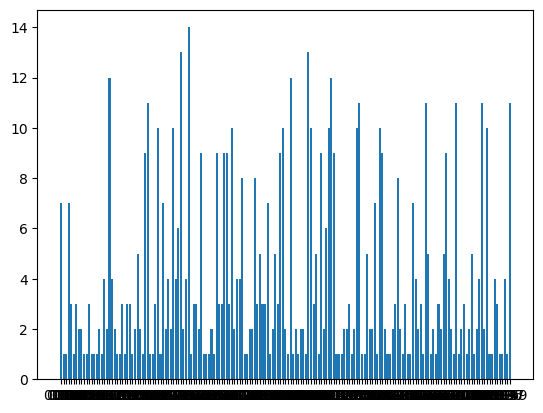

In [51]:
plt.bar(st,ct)

In [6]:
#getting the center coordinate of all sites
epsg_code = gdf.crs.to_epsg()
print(f"The current projection is: EPSG {epsg_code}\n Reporjecting to WGS84 (EPSG 4326)")
source_projection = Proj(init=f'epsg:{epsg_code}')
target_projection = Proj(init='epsg:4326')  # WGS84

#epsgcenterlist=[]
wgscenterlist=[]
for geom in geometry:
    x, y = geom.centroid.x, geom.centroid.y
    lon, lat = transform(source_projection, target_projection, x, y)
    #epsgcenterlist.append([x, y])
    wgscenterlist.append([lon, lat])
np.save('Data/'+Case+'/masklayers/wgscenterlist.npy', wgscenterlist)

The current projection is: EPSG 5070
 Reporjecting to WGS84 (EPSG 4326)


c:\Users\Vito\miniconda3\envs\gee\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\Vito\miniconda3\envs\gee\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\Vito\AppData\Local\Temp\ipykernel_9712\1492638990.py:11: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-

In [5]:
#MODIS NDVI download
NDVI_failed_sites = []
step=1
for i in tqdm(np.arange(77,101,1),'Downloading '+Case+' NDVI', unit='site'):
    try:
        templist=[]
        for yt in np.arange(2006,2023,step):
            templist.append(getsiteNDVI(roiall, NDVICollection, i, f'{yt}-01-01', f'{yt+step}-01-01', 30))
        St=pd.concat(templist, axis=0, join='inner')
        St.to_hdf(sites_pth+f'/Site{i:03}_NBARint.h5', key='df', mode='w')
    except Exception as e:
        print(f"Error: download failed for site {i} at year {yt}")
        NDVI_failed_sites.append(i)  
print(f"Failed sites: {NDVI_failed_sites}")

Error: download failed for site 81 at year 2015


Error: download failed for site 88 at year 2008


Failed sites: ['81_2015', '88_2008']


In [6]:
#MODIS NDVI download
NDVI_failed_sites = []
step=1
for i in tqdm(np.arange(102,150,1),'Downloading '+Case+' NDVI', unit='site'):
    try:
        templist=[]
        for yt in np.arange(2006,2023,step):
            templist.append(getsiteNDVI(roiall, NDVICollection, i, f'{yt}-01-01', f'{yt+step}-01-01', 30))
        St=pd.concat(templist, axis=0, join='inner')
        St.to_hdf(sites_pth+f'/Site{i:03}_NBARint.h5', key='df', mode='w')
    except Exception as e:
        print(f"Error: download failed for site {i} at year {yt}")
        NDVI_failed_sites.append(i)  
print(f"Failed sites: {NDVI_failed_sites}")

Failed sites: []


In [5]:
#MODIS NDVI download
NDVI_failed_sites = []
step=1
for i in tqdm(np.arange(170,num_sites,1),'Downloading '+Case+' NDVI', unit='site'):
    try:
        templist=[]
        for yt in np.arange(2006,2023,step):
            templist.append(getsiteNDVI(roiall, NDVICollection, i, f'{yt}-01-01', f'{yt+step}-01-01', 30))
        St=pd.concat(templist, axis=0, join='inner')
        St.to_hdf(sites_pth+f'/Site{i:03}_NBARint.h5', key='df', mode='w')
    except Exception as e:
        print(f"Error: download failed for site {i} at year {yt}")
        NDVI_failed_sites.append(i)  
print(f"Failed sites: {NDVI_failed_sites}")

Failed sites: []


In [ ]:
#NDVI download
failed_sites = []
for i in [12,26,27,73,89]:
    templist=[]
    for yt in np.arange(2006,2023,1):
        try:
            templist.append(getsiteNDVI(roiall, NDVICollection, i, f'{yt}-01-01', f'{yt}-04-01', 30))
            templist.append(getsiteNDVI(roiall, NDVICollection, i, f'{yt}-04-01', f'{yt}-07-01', 30))
            templist.append(getsiteNDVI(roiall, NDVICollection, i, f'{yt}-07-01', f'{yt}-10-01', 30))
            templist.append(getsiteNDVI(roiall, NDVICollection, i, f'{yt}-10-01', f'{yt+1}-01-01', 30))
        except Exception as e:
            print(f"Error: download failed for site {i} year {yt}")
            failed_sites.append(f'{i}_{yt}')
    St=pd.concat(templist, axis=0, join='inner')
    St.to_hdf(sites_pth+f'/Site{i:03}_NBARint.h5', key='df', mode='w')
print(f"Failed sites: {failed_sites}")

problem for season download
site 12
26
73
79
89
works after spliting in 5 years

In [ ]:
#NDSI season download
NDSI_failed_sites = []
for i in tqdm(np.arange(0,num_sites,1),'Downloading '+Case+' NDSI', unit='site'):
    try:
        d1,snow1,lst1=Season(roiall, i, 2006, 2013)
        d2,snow2,lst2=Season(roiall, i, 2013, 2023)
        St1=pd.concat([d1,d2], axis=0, join='inner')
        St1.to_hdf(season_pth+f'/Site{i:03}_season_day.h5', key='df', mode='w')
        St2=pd.concat([snow1,snow2], axis=0, join='inner')
        St2.to_hdf(season_pth+f'/Site{i:03}_snow_ts.h5', key='df', mode='w') 
        St3=pd.concat([lst1,lst2], axis=0, join='inner')
        St3.to_hdf(season_pth+f'/Site{i:03}_lst_ts.h5', key='df', mode='w') 

    except Exception as e:
        print(f"Error: download failed for site {i}")
        NDSI_failed_sites.append(i)
print(f"Failed sites: {NDSI_failed_sites}")

Error: download failed for site 12


In [15]:
#season download splited
run=0
while len(NDSI_failed_sites)>0:
    print(f"Retrying sites: {NDSI_failed_sites}")
    new_NDSI_failed_sites = []
    for i in tqdm(NDSI_failed_sites,'Downloading '+Case+' NDSI', unit='site'):
        try:
            d1,snow1,lst1=Season(roiall, i, 2006, 2010)
            d2,snow2,lst2=Season(roiall, i, 2010, 2015)
            d3,snow3,lst3=Season(roiall, i, 2015, 2020)
            d4,snow4,lst4=Season(roiall, i, 2020, 2023)
            
            St1=pd.concat([d1,d2,d3,d4], axis=0, join='inner')
            St1.to_hdf(season_pth+f'/Site{i:03}_season_day.h5', key='df', mode='w')
            St2=pd.concat([snow1,snow2,snow3,snow4], axis=0, join='inner')
            St2.to_hdf(season_pth+f'/Site{i:03}_snow_ts.h5', key='df', mode='w') 
            St3=pd.concat([lst1,lst2,lst3,lst4], axis=0, join='inner')
            St3.to_hdf(season_pth+f'/Site{i:03}_lst_ts.h5', key='df', mode='w') 

        except Exception as e:
            print(f"Error: download failed for site {i}")
            new_NDSI_failed_sites.append(i)
    if NDSI_failed_sites == new_NDSI_failed_sites:
        print(f"Error: number of failed sites not reducing. May need further splitting")
        break
    NDSI_failed_sites = new_NDSI_failed_sites
    print(f"Failed sites: {failed_sites}")

12
26
73
79
89
Failed sites: []


In [ ]:
#site cdl donwload
cdl_failed_sites = []
for i in tqdm(np.arange(0,num_sites,1),'Downloading '+Case+' CDL', unit='site'):
    try:
        temp=cdldf(cdl, i)
        temp.to_hdf(cdl_pth+f'/Site{i:03}_cdl.h5', key='df', mode='w') 
    except Exception as e:
        print(f"Error: download failed for site {i}")
        cdl_failed_sites.append(i)
print(f"First run failed sites: {cdl_failed_sites}")

Error: download failed for site 121
Failed sites: [121]


In [ ]:
run=0
while len(cdl_failed_sites)>0:
    new_cdl_failed_sites = []
    for i in tqdm(cdl_failed_sites,'Downloading '+Case+' CDL', unit='site'):
        try:
            temp=cdldf(cdl, i)
            temp.to_hdf(cdl_pth+f'/Site{i:03}_cdl.h5', key='df', mode='w') 
        except Exception as e:
            print(f"Error: download failed for site {i}")
            new_cdl_failed_sites.append(i)
    cdl_failed_sites = new_cdl_failed_sites
    print(f"Failed sites run {run}: {cdl_failed_sites}")

In [9]:
#sentinel 1 donwload
failed_sites = []
for i in tqdm(np.arange(0,num_sites,1),'Downloading '+Case+' Sentinel 1', unit='site'):
    templist=[]
    try:
        df = s1data(2015, 2023, i, direction = 'Decending', orbit = None, dataset='LOG')
        df.to_hdf(sentinel1_pth+f'/Site{i:03}_db.h5', key='df', mode='w') 

    except Exception as e:
        print(f"Error: download failed for site {i}")
        failed_sites.append(i)
print(f"Failed sites: {failed_sites}")

Failed sites: []
